<a href="https://colab.research.google.com/github/VRehnberg/AISC5-ID/blob/master/visualising_neuron_dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizations
There are three kinds of relevant visulizations:
 * Visualizing activations
 * Visualizing the embeddings used for regularisation
   * Sorted correlation matrix
   * Between clusters
 * Visualizing intrinsic dimension (ID) of modules and module unions

## Import pacakges

In [93]:
# Utilities and numerics
import gc
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from functools import partial
from importlib.util import find_spec
from collections.abc import Iterable


# Machine-learning
import torch
import torchvision
from torch import nn, optim
from torch.autograd.functional import jacobian

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Clustering
from sklearn import manifold
from sklearn.manifold import TSNE


# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
if find_spec("matplotlib_venn") is None:
    !pip install matplotlib-venn
from matplotlib_venn import venn2, venn3
if find_spec("upsetplot") is None:
    !pip install upsetplot
import upsetplot

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 140



## Load dataset

In [94]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainset_raw = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, num_workers=2)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10


## Utilities

In [95]:
class MLP(nn.Module):
    def __init__(self, layers, Activation=nn.ReLU):
        super().__init__()
        self.input_shape = layers[0]
        hidden = [
            layer
            for li, lo in zip(layers, layers[1:])
            for layer in [nn.Linear(li, lo), Activation()]
        ][:-1]
        self.hidden = nn.ModuleList(hidden)

    def forward(self, x):
        x = x.view(-1, self.input_shape)
        for layer in self.hidden:
            x = layer(x)
        return x


def get_activations(network, x):
    activations = []
    hooks = []
    for name, m in network.named_modules():
        if type(m) == nn.Linear:
            save_activations = lambda mod, inp, out: activations.append(out)
            hooks.append(m.register_forward_hook(save_activations))
    
    network(x)
    for h in hooks:
        h.remove()
    
    return torch.hstack(activations)


def batched_jacobian(func, x):
    '''Calculate an unoptimized jacobian for batches.'''
    x_shape = x.shape[1:]
    def flattened_func(x_flattened):
        y = func(x_flattened.reshape(x_shape))
        return y.flatten()
    
    jacs = []
    for x_sample in tqdm(x, desc="Jac"):

        jacs.append(jacobian(flattened_func, x_sample.flatten()))
    
    jac = torch.stack(jacs, dim=0)
    return jac


def compute_adjacency_matrix(embedding):
    '''Compute correlation based adjacency matrix from embedding.'''
    centered_embedding = embedding - embedding.mean()
    centered_embedding = centered_embedding / centered_embedding.abs().mean()
    cov = centered_embedding @ centered_embedding.T
    inv_std = 1 / cov.diag().sqrt()
    corr = cov * inv_std * inv_std.unsqueeze(1)
    adj_mat = corr ** 2
    return adj_mat


def compute_laplacian(embedding):
    '''Computes normalized Laplacian from embedding.
    
    Parameters:
        embedding (Tensor): n_neurons × n_features
    
    Returns:
        lap (Tensor): n_neurons × n_neurons
    '''
    # Compute adjacency matrix
    adj_mat = compute_adjacency_matrix(embedding)

    # Compute normalized laplacian
    inv_sqrt_degree = 1 / adj_mat.sum(0, keepdims=True).sqrt()
    adjnorm = adj_mat * inv_sqrt_degree * inv_sqrt_degree.T
    lap = torch.eye(adjnorm.shape[0], device=device) - adjnorm

    return lap


def clean_mem():
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()


## Creating an example network

In [96]:
%%time
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
mlp = MLP(layers).to(device)

n_epochs = 10
optimizer = optim.Adam(mlp.parameters(), lr=0.01)

n_batches = len(trainloader)
pbar = tqdm(desc="Train", total=(n_epochs * n_batches))
for epoch in range(n_epochs):

    batch_loss = 0.0
    batch_actloss = 0.0
    batch_acc = 0.0
    for i_batch, (x, y) in enumerate(trainloader):
        batch_is_final = (i_batch + 1 == n_batches)
        x, y = x.to(device), y.to(device)
        mlp.train()
        optimizer.zero_grad()

        y_estimate = mlp(x)

        # Usual loss
        loss = nn.CrossEntropyLoss()(y_estimate, y)
        batch_loss += loss.detach().cpu()
        
        # Accuracy
        batch_acc += (torch.argmax(y_estimate, dim=1) == y).float().mean().detach().cpu()
        pbar.update(1)

        # Update network parameters
        loss.backward()
        optimizer.step()

        # This is only useful if the not the whole dataset is traversed
        if batch_is_final:
            break

    # Print metrics for this epoch
    avg_acc = batch_acc / n_batches
    avg_loss = batch_loss / n_batches
    pbar.write(f'Epoch {epoch}. Acc {avg_acc:.4f}, CE: {avg_loss:.4f}')

    clean_mem()


Epoch 0. Acc 0.7229, CE: 0.7531
Epoch 1. Acc 0.8458, CE: 0.4231
Epoch 2. Acc 0.8630, CE: 0.3729
Epoch 3. Acc 0.8738, CE: 0.3412
Epoch 4. Acc 0.8757, CE: 0.3346
Epoch 5. Acc 0.8821, CE: 0.3163
Epoch 6. Acc 0.8863, CE: 0.3049
Epoch 7. Acc 0.8924, CE: 0.2900
Epoch 8. Acc 0.8929, CE: 0.2905
Epoch 9. Acc 0.8968, CE: 0.2769
CPU times: user 5.73 s, sys: 1.66 s, total: 7.4 s
Wall time: 1min 12s


## Cluster into modules

In [97]:
def kmeans(
    points,
    k,
    global_start=1,
    max_iter=None,
    reinitialize_empty_clusters=True,
    verbose=False,
):
    '''Naive K-means with parallelized global start.
    
    Arguments:
        points (Tensor): Number of points times number of features.
        k (int): Number of clusters.
        global_start (int): Different intializations that are run in parallel.
            Default 1.
        max_iter (int): Maximum number of iterations or None. Default None.
        reinatialize_empty_clusters (bool): If empty clusters are reinitialized.
            Default True.
        verbose (bool): Controls verbosity. Default True. 
    '''
    if len(points.shape) > 2:
        raise NotImplementedError("Batches not implemented.")

    emb_dim = points.shape[-1]
    n_points = points.shape[0]
    device = points.device
    
    # Initialize centroids randomly from points
    rng_idx = torch.randperm(global_start * n_points, device=device) % n_points
    centroids = points[rng_idx].reshape(global_start, *points.shape)[:, :k, :]
    points = points.unsqueeze(0).tile((global_start, 1, 1))
    
    converged = False
    iter = 0
    while not converged:
        if verbose:
            print("Iter", iter, end=" ")
        if max_iter and (iter > max_iter):
            warnings.warn("Algorithm finished prematurely. Consider increasing max_iter.", RuntimeWarning)
            break
        # Assign to clusters
        distances = torch.cdist(points, centroids).pow(2)
        distances, i_cluster = distances.min(-1)
        i_cluster = i_cluster.unsqueeze(2).tile((1, 1, emb_dim))

        ## Remove duplicate parallel searches
        #i_cluster, ix = torch.unique(i_cluster, dim=0, return_index=True)
        #points = points[ix, :, :]
        #centroids = centroids[ix, :, :]

        # Move centroids
        for i in range(k):
            is_in_cluster = (i_cluster == i)
            #assert (is_in_cluster.all(dim=-1)==is_in_cluster.any(dim=-1)).all()
            old_centroids = centroids.clone()
            centroids[:, i, :] = (
                (is_in_cluster.float() * points).sum(dim=1)
                / is_in_cluster[:, :, :1].sum(dim=1)
            )

            # Reinitialize unused centroids
            if reinitialize_empty_clusters:
                i_empty_cluster = (is_in_cluster.sum((1, 2)) == 0).nonzero(
                    as_tuple=True
                )[0]
                n_new_centroids = i_empty_cluster.nelement()
                i_random_points = torch.randint(
                    n_points,
                    (n_new_centroids,),
                    device=device,
                )
                new_centroids = points[i_empty_cluster, i_random_points, :]
                centroids[i_empty_cluster, i, :] = new_centroids
    
        # Check convergence
        cluster_converged = torch.isclose(centroids, old_centroids).flatten(1).all(1)
        if iter > 0:
            ssd_converged = torch.isclose(distances.sum(1), old_distances.sum(1))
            assert ssd_converged.shape == cluster_converged.shape
            cluster_converged |= ssd_converged
        old_distances = distances.clone()

        n_converged = cluster_converged.int().sum().item()
        if verbose:
            print(f"{n_converged}/{global_start} have converged.")
        converged = (n_converged == global_start)
        iter += 1

    assert (i_cluster.diff(dim=2)==0).all(), "This should've been tiled. Hmm."

    # Pick best clusters
    i_best = distances.sum(-1).argmin()
    i_cluster = i_cluster[i_best, :, 0]
    
    assert i_cluster.min() >= 0
    assert i_cluster.max() <= k

    return i_cluster


def cluster_network(network, k=3, batch_size=1024, **kmeans_kws):
    x = torch.vstack([
        trainset[i][0]
        for i in torch.randperm(len(trainset))[:batch_size]
    ]).to(device)
    jac = batched_jacobian(partial(get_activations, network), x)
    emb = jac.permute(1, 2, 0).flatten(1)
    lap = compute_laplacian(emb)
    eigval, eigvec = torch.symeig(lap, eigenvectors=True)
    eigvec = eigvec[:, :k]
    i_module = kmeans(eigvec, k, **kmeans_kws)
    return i_module


In [98]:
%%time
n_modules = 3

i_module = cluster_network(mlp, k=n_modules, global_start=10, max_iter=100)



CPU times: user 58 s, sys: 3.92 s, total: 1min 1s
Wall time: 1min 3s


## Visualizing activations

In [99]:
# Layer labels for neurons
# NB this assumes that named modules appear in order of their execution
i_layer = []
layer_counter = 1
for name, mod in mlp.named_modules():
    if isinstance(mod, nn.Linear):
        n_neurons = mod.out_features
        i_layer.extend(n_neurons * [layer_counter])
        layer_counter += 1
i_layer = np.array(i_layer)

In [100]:
i_random = np.random.randint(n_modules, size=i_layer.shape)

<mark>N.B.</mark> the TSNE below uses the Euclidian distance between activations which is probably not the right metric and there is some dependence on the perplexity score so the clustering (especially for small values (perplexity should generally be between 5 and 50 I think)) might be due to noise.

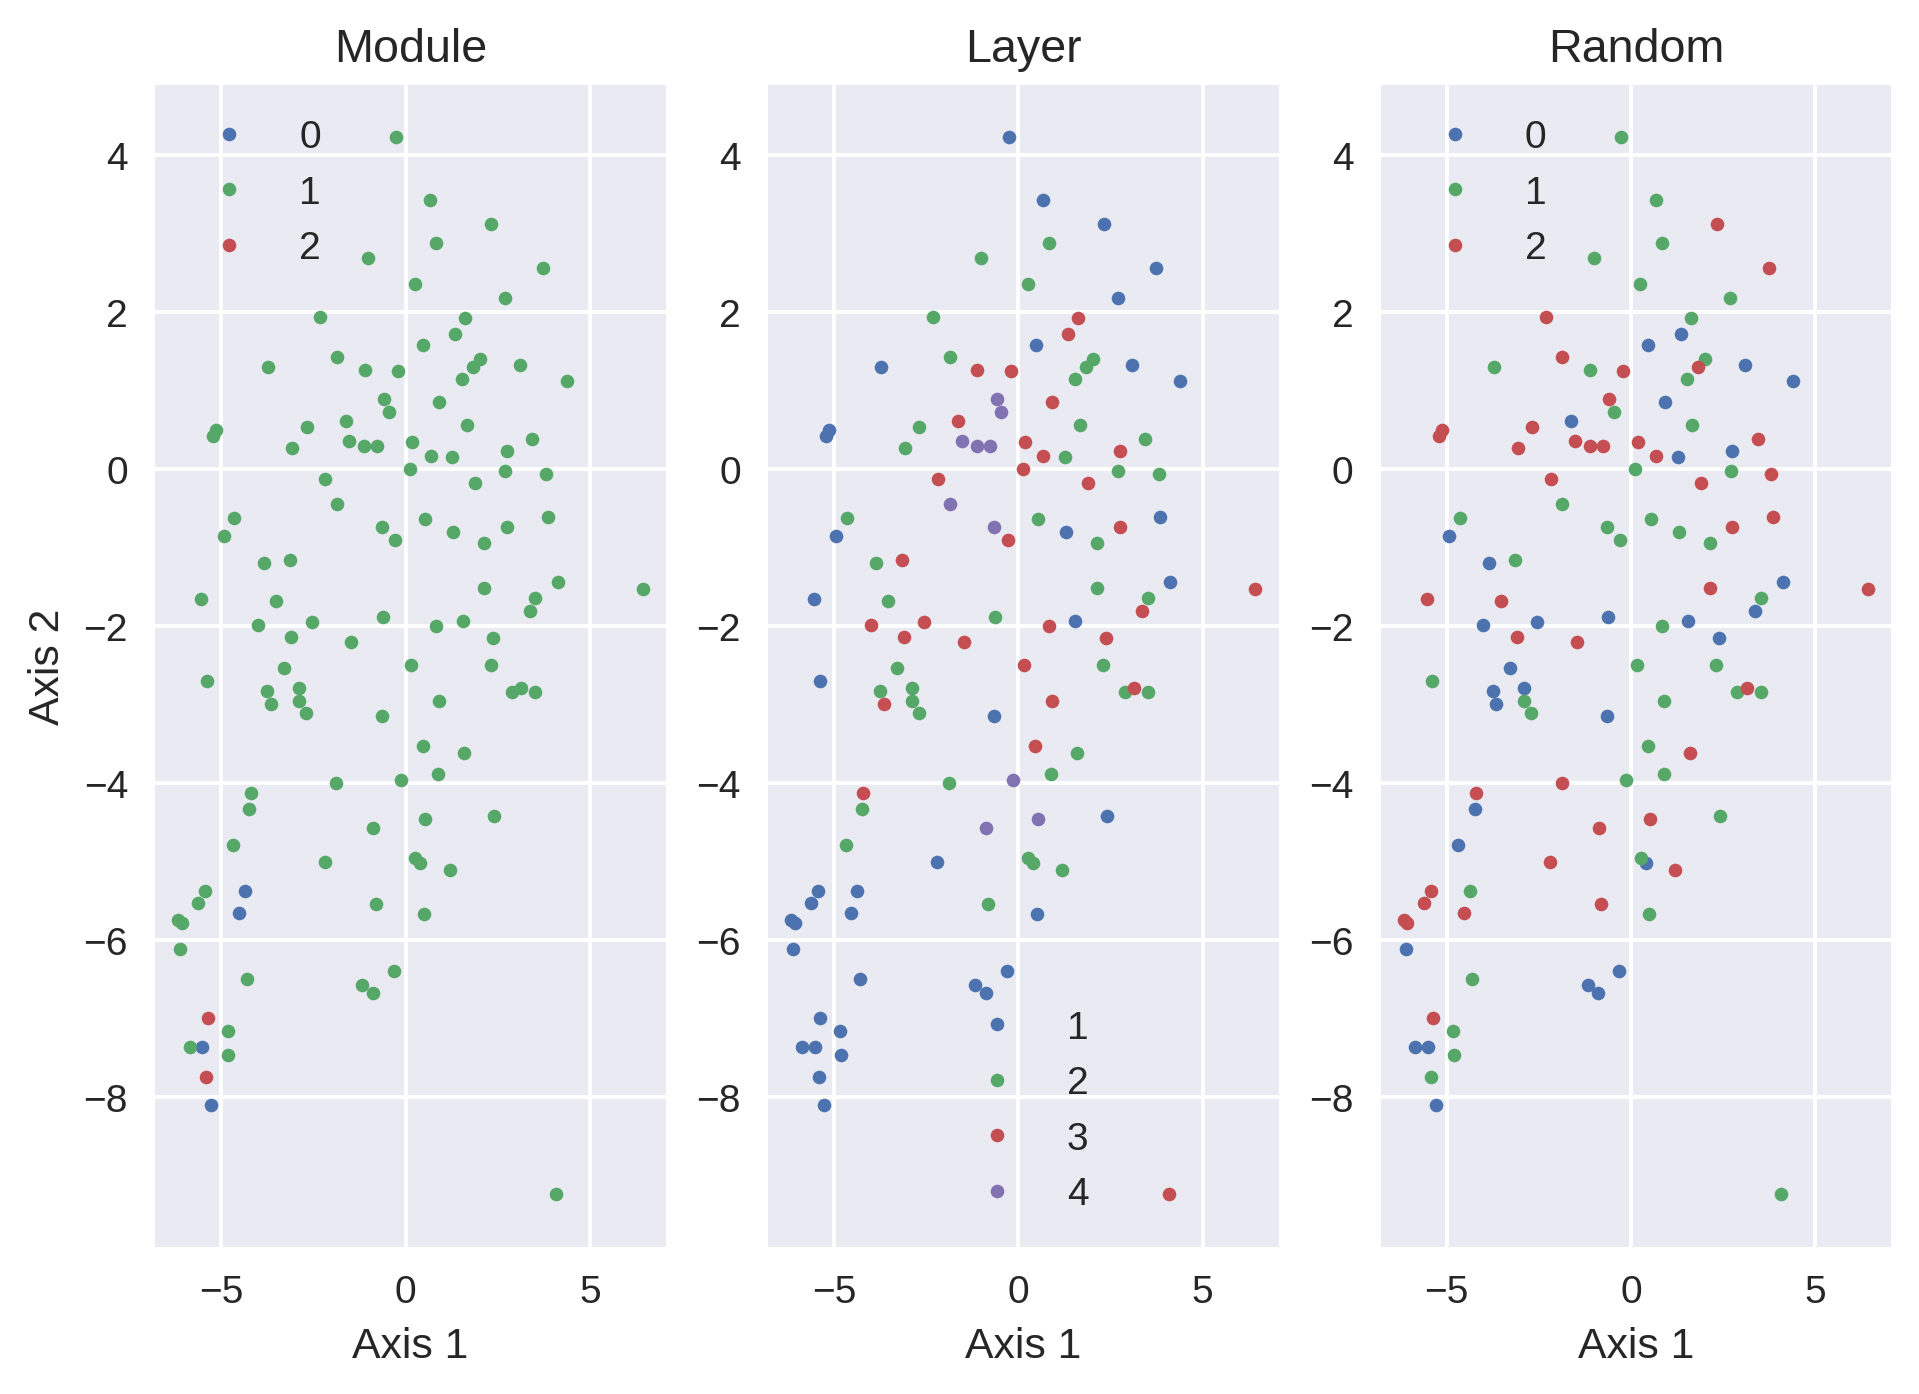

In [101]:
# Project activations to 2D plane
activations = []
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        activations.append(get_activations(mlp, x))
activations = torch.cat(activations, dim=0).detach().cpu().numpy()
n_activations = activations.shape[1]

perplexity = n_activations // n_modules
embedded = TSNE(
    n_components=2,
    perplexity=perplexity,
).fit_transform(activations.T)

# Plot projections
groupings = {
    "Module" : i_module.detach().cpu().numpy(),
    "Layer" : i_layer,
    "Random" : i_random,
}
fig, axs = plt.subplots(1, len(groupings))
if not isinstance(axs, Iterable):
    axs = [axs]

x, y = embedded[:, 0], embedded[:, 1]
for ax, grouping in zip(axs, groupings.items()):
    name, i_group = grouping
    ax.set_title(name)
    for i in np.unique(i_group):
        mask = (i_group == i)
        ax.plot(x[mask], y[mask], '.', label=i)
    ax.legend()
    ax.set_xlabel("Axis 1")
axs[0].set_ylabel("Axis 2")

clean_mem()


## Visualizing Jacobian correlations

In [102]:
batch_size = 1024
x = torch.vstack([
    testset[i][0]
    for i in torch.randperm(len(testset))[:batch_size]
]).to(device)
jac = batched_jacobian(partial(get_activations, mlp), x)
emb = torch.cat(jac.unbind(0), dim=1)
adj_mat = compute_adjacency_matrix(emb)

clean_mem()


In [103]:
distances = (1 - adj_mat).sqrt().nan_to_num().detach().cpu().numpy()
i_tsne = np.argsort(np.argsort(
    TSNE(1, perplexity=perplexity, metric="precomputed").fit_transform(distances)
)).squeeze()
groupings["tSNE"] = i_tsne

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


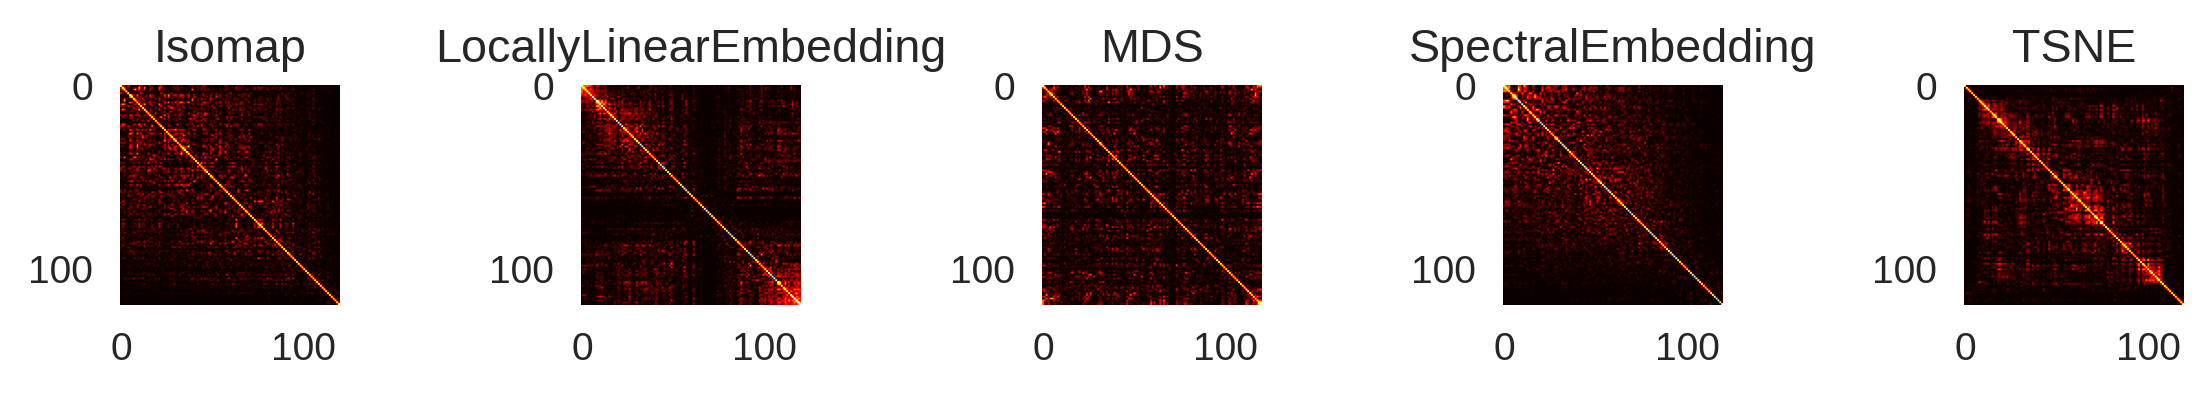

In [104]:
manifold_kwargs = dict(
    n_components=1,
)
embedders = [ 
    manifold.Isomap(metric="precomputed", **manifold_kwargs),
    manifold.LocallyLinearEmbedding(**manifold_kwargs),
    manifold.MDS(metric="precomputed", **manifold_kwargs),
    manifold.SpectralEmbedding(**manifold_kwargs),
    manifold.TSNE(perplexity=20, metric="precomputed", **manifold_kwargs),
]
fig, axs  = plt.subplots(1, len(embedders))

image = adj_mat.detach().cpu().numpy()
distances = (1 - adj_mat).sqrt().nan_to_num().detach().cpu().numpy()

for ax, embedder in zip(axs, embedders):
    # Sort image order
    embedding = embedder.fit_transform(distances).squeeze()
    i_sort = np.argsort(embedding)
    sorted_image = image[i_sort, :][:, i_sort]
    
    # Add image
    ax.set_title(type(embedder).__name__)
    ax.imshow(sorted_image, vmin=0, vmax=1, cmap="hot")
    
    # Axis ticks
    ax.grid(False)

fig.tight_layout()

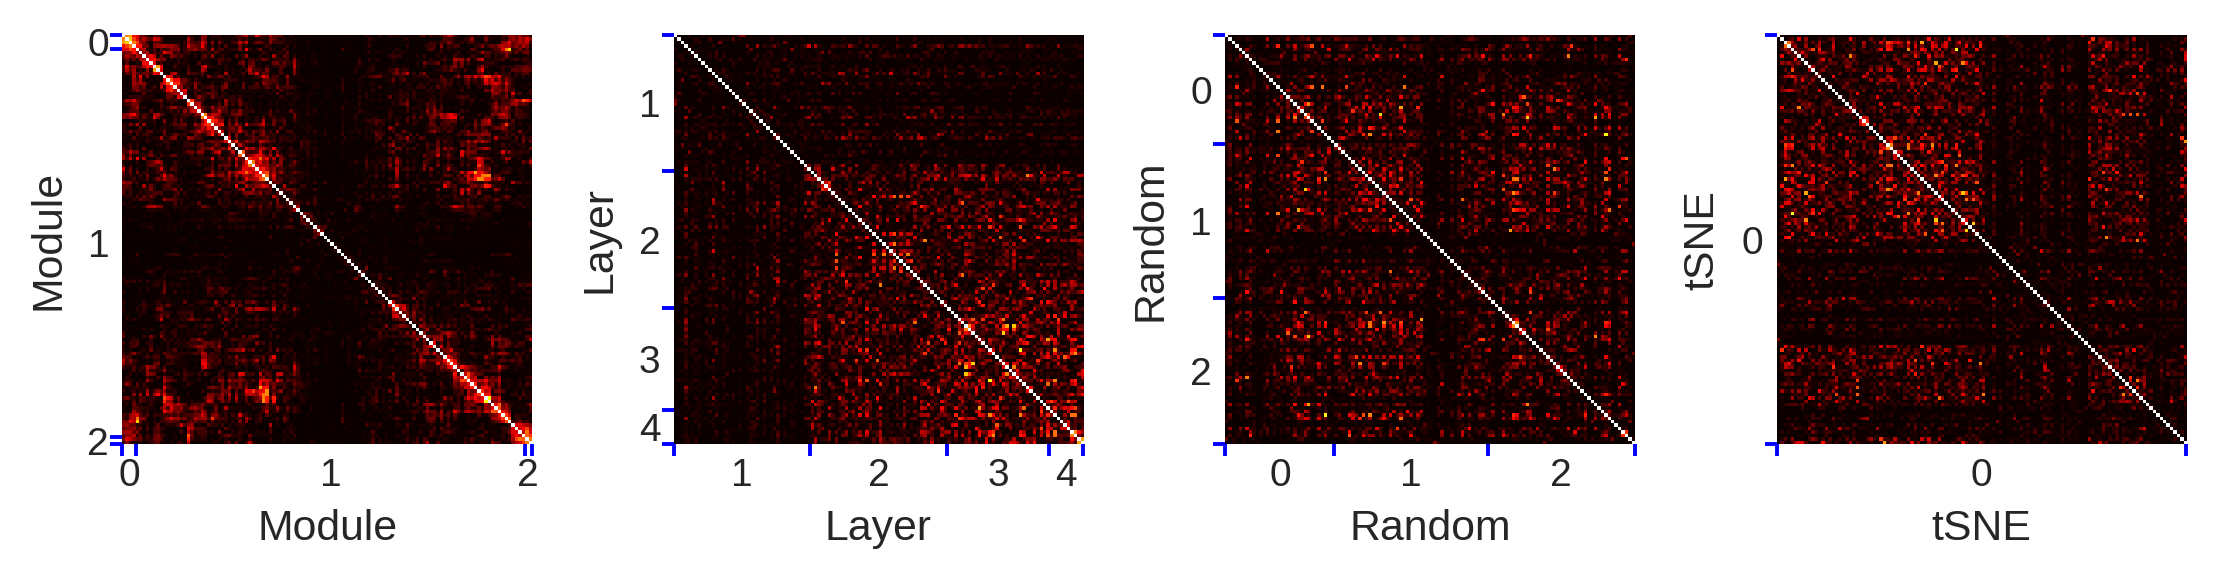

In [105]:
fig, axs  = plt.subplots(1, len(groupings))

for ax, grouping in zip(axs, groupings.items()):
    name, i_group = grouping
    
    # Sort image order
    image = adj_mat.detach().cpu().numpy()
    if name == "Module":
        tmp = (1 - adj_mat).sqrt().detach().cpu().numpy()
        tmp[np.isnan(tmp)] = 0
        tsne_embedding = TSNE(1, perplexity=20.0).fit_transform(tmp).squeeze()
        i_sort = np.argsort(tsne_embedding)
    else:
        i_sort = np.argsort(i_group)
    image = image[i_sort, :][:, i_sort]
    
    # Add image
    ax.imshow(image, vmin=0, vmax=1, cmap="hot")
    
    # Axis ticks
    ax.grid(False)
    ax.tick_params(axis="both", direction='out', length=3, width=1, colors='b')
    ax.tick_params(direction='out', length=3, width=1, colors='b')
    xticklabels, counts = np.unique(i_group, return_counts=True)
    xticklabels = [f"{x:d}" for x in xticklabels]
    xticks = np.zeros(len(counts) + 1) - 0.5
    xticks[1:] += np.cumsum(counts)
    minor_xticks = (xticks[0:-1] + xticks[1:]) / 2
    for subax in [ax.xaxis, ax.yaxis]:
        subax.set_major_locator(ticker.FixedLocator(xticks))
        subax.set_major_formatter(ticker.NullFormatter())
        subax.set_minor_locator(ticker.FixedLocator(minor_xticks))
        subax.set_minor_formatter(ticker.FixedFormatter(xticklabels))
        for tick in subax.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")

    ax.set_xlabel(name)
    ax.set_ylabel(name);

fig.tight_layout()


## Visualizing intrinsic dimension.

In [106]:
def get_jacobian_dimension(jac):
    '''Calculates the intrinsic dimension based on the Jacobian.'''
    rank = torch.matrix_rank(jac, symmetric=False)
    # N.B. mean is perhaps not the summary statistic that is most meaningful
    rank = rank.float().mean(0).detach().cpu().numpy()
    return rank


def get_twonn_dimension(points, fit_fraction=0.9, plot=False):
    '''Calculates the intrinsic dimension of the the input.
    The algorithm that is used is TwoNN [1].

    Arguments:
        points (Tensor): Size is (batch_size ×) n_points × embedding_dimension
        fit_fraction (float): Fraction of points to use in fit.
            "By discarding the last points the measure is closer to the ground
            truth, the fit is more stable and the overall procedure more
            reliable" [1].
        plot (bool): If fit should be visualized. Default False.


    References:
    [1] E. Facco, M. d’Errico, A. Rodriguez & A. Laio
        Estimating the intrinsic dimension of datasets by a minimal
        neighborhood information (https://doi.or/g/10.1038/s41598-017-11873-y)
    '''
    if not isinstance(points, torch.Tensor):
        raise TypeError("Input should be a Tensor.")
    if len(points.shape) > 3 or len(points.shape) < 2:
        raise ValueError("Input should be 2 or 3 dimensional.")
    
    # Massage points tensor
    points = points.float()
    no_batch = False
    if len(points.shape) == 2:
        no_batch = True
        points = points.unsqueeze(0)
    
    # Get information from points
    batch_size = points.shape[0]
    n_points = points.shape[-2]
    n_dim = points.shape[-1]
    dtype = points.dtype
    device = points.device
    eps = torch.finfo(dtype).eps

    if n_points < 3:
        raise ValueError("TwoNN needs atleast three points to work.")
    if 1.0 < fit_fraction or fit_fraction <= 0.0:
        raise ValueError("Parameter fit_fraction must be in (0, 1].")

    
    # Compute pairwise distances
    distances = torch.cdist(points, points, p=2)
    distances, _ = distances.topk(3, dim=-1, largest=False)
    
    # Compute µ = r_2 / r_1
    r0, r1, r2 = torch.split(distances, 1, dim=-1)
    mu = (r2 + eps) / (r1 + eps)
    if not ((mu > 1.0) | (torch.isclose(mu, torch.ones(1, device=device)))).all():
        raise RuntimeError("Something went wrong when computing µ.")

    # Compute the empirical cumulate
    empirical = (
        torch.arange(n_points, dtype=mu.dtype, device=device) / n_points
    ).tile(batch_size, 1).unsqueeze(2)
    mu, _ = mu.sort(dim=1)

    # Fit the the intrinsic dimension
    # d = - log(1 - F(µ)) / log(µ)
    y_full = - torch.log(1.0 - empirical)
    x_full = torch.log(mu)
    
    n_fit = int(round(fit_fraction * n_points))
    y_fit = y_full[:, :n_fit]
    x_fit = x_full[:, :n_fit]

    # Here assume that the values of log(1 - F(µ)) are exact and
    # log(µ) is drawn from a normal distribution (prob. not correct).
    # I.e. 1 / d* = argmin_(1 / d) ||(-log(1 - F(µ))) (1 / d) - µ||_2 )
    # TODO do a proper Bayesian analysis for the fit
    inv_d = torch.bmm(
        torch.pinverse(y_fit),
        x_fit,
    )
    intrinsic_dimension = 1.0 / inv_d[:, 0]

    if plot and batch_size > 1:
        warnings.warn("Plotting when batch_size > 1 is not possible.")
    
    elif plot and batch_size==1:
        x_full = x_full.squeeze(0)
        y_full = y_full.squeeze(0)
        x_fit = x_fit.squeeze(0)
        y_fit = y_fit.squeeze(0)

        # Add data points
        plt.plot(x_full, y_full, ".", c="grey", label="All points")
        plt.plot(x_fit, y_fit, ".", c="pink", label="Fit points")
        xlim = plt.xlim()
        ylim = plt.ylim()

        # Add line
        x_plot = torch.Tensor([0, xlim[1]])
        y_plot = intrinsic_dimension.squeeze(0) * x_plot
        label = f"Fit (ID={intrinsic_dimension.squeeze():.2g})"
        plt.plot(x_plot, y_plot, "-", c="cyan", zorder=1.5, label=label)

        # Axis
        plt.legend()
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.xlabel(r"$log(\mu)$")
        plt.ylabel(r"$-log(1 - F(\mu))$")
    
    if no_batch:
        intrinsic_dimension = intrinsic_dimension.squeeze(0)
    
    return intrinsic_dimension.squeeze(-1)


In [107]:
def get_intrinsic_dimensions(method, values, i_group, group_name=""):
    '''Calculates the intrinsic dimension for modules and union of modules.'''
    
    def calc_id(mask):
        if method=="jacobian":
            subjac = values[:, mask, :]
            id = get_jacobian_dimension(subjac)
        elif method=="twonn":
            subpoints = values[:, mask]
            id = get_twonn_dimension(subpoints).detach().cpu().numpy()
        else:
            raise NotImplementedError(f'Method "{method}" is not implemented.')

        return id

    intrinsic_dimensions = {}
    module_names = i_group.unique()
    n_modules = len(module_names)
    for r in range(1, n_modules + 1):
        for module_combination in itertools.combinations(module_names, r):
            # Select sub-Jacobian for this union of modules
            mask = torch.zeros_like(i_group, dtype=bool)
            for module_name in module_names:
                if module_name in module_combination:
                    mask |= (i_group == module_name)
                else:
                    assert not (mask & (i_group == module_name)).any()
            if mask.any():
                id = calc_id(mask)
            else:
                id = 0
            name = " U ".join([f"{group_name}{n}" for n in module_combination])
            intrinsic_dimensions[name] = id
    
    assert len(intrinsic_dimensions) == 2**n_modules - 1
    return intrinsic_dimensions


def calculate_subsets(unions):
    set_names = np.unique(np.hstack(
        [union_name.split(" U ") for union_name in unions]
    ))
    k = len(set_names)
    n_disjoint_subsets = 2**k - 1
    set_ids = np.arange(n_disjoint_subsets).reshape(-1, 1) + 1
    in_set = np.unpackbits(np.fliplr(set_ids.view(np.uint8)), axis=1)[:, -k:] == 1

    # Build system of linear equations
    system = np.zeros(2 * [n_disjoint_subsets], dtype=int)
    for i_row, union_name in enumerate(unions):
        union_id = np.array([name in union_name for name in set_names])
        system[i_row, :] = (union_id & in_set).any(axis=1) 
    
    union_values = np.array(list(unions.values()))
    disjoint_counts = np.linalg.solve(system, union_values)
    
    return in_set, disjoint_counts


def sort_subsets(in_set, subset_counts):
    n_rows = subset_counts.shape[0]
    assert len(in_set.shape) < 3
    assert in_set.shape[0] == n_rows
    in_set = in_set.reshape(n_rows, -1)
    n_sets = in_set.shape[1]

    key = lambda row: sum([b*2**i for i, b in enumerate(in_set)])
    i_sort = (in_set @ (2 ** np.arange(n_sets)).reshape(-1, 1)).flatten() - 1
    return in_set[i_sort], subset_counts[i_sort]


def plot_disjoint_subsets(unions, quantity="ID"):
    in_set, subset_counts = calculate_subsets(unions)
    in_set, subset_counts = sort_subsets(in_set, subset_counts)
    
    n_bases = int(round(np.log2(len(subset_counts) + 1)))
    names = np.unique(np.hstack([name.split(" U ") for name in unions]))
    
    name = names[0][:-1]
    print(f"{quantity}s w.r.t. {name} are {subset_counts}.")
    
    if n_bases > 1:
        fig = plt.figure()
        if n_bases <= 3:
            ax = plt.axes()
            fig.add_axes(ax)
            venn_kws = dict(
                subsets=subset_counts,
                set_labels=names,
                ax=ax,
                subset_label_formatter=lambda v: f'{round(v, 2):g}'
            )
    else:
        fig = None
    
    if n_bases==1:
        print(f"{quantity} is {subset_counts[0]}.")
    if n_bases==2:
        venn2(**venn_kws)
    elif n_bases==3:
        venn3(**venn_kws)
    elif n_bases>=4:
        multi_idx = pd.MultiIndex.from_arrays(in_set.T, names=names)
        if (subset_counts < 0).any():
            warnings.warn(f"There were negative {quantity}, this won't show right. Setting these to zero.")
            subset_counts = np.clip(subset_counts, 0, None)
        df = pd.Series(data=subset_counts, index=multi_idx)
        upsetplot.plot(df, fig=fig, orientation="vertical")
    
    return fig


Unions are:
 Module0=4, Module1=114, Module2=2, Module0 U Module1=118, Module0 U Module2=6, Module1 U Module2=116, Module0 U Module1 U Module2=120
#neuronss w.r.t. Module are [  4. 114.   0.   2.  -0.  -0.   0.].
Unions are:
 Layer1=40, Layer2=40, Layer3=30, Layer4=10, Layer1 U Layer2=80, Layer1 U Layer3=70, Layer1 U Layer4=50, Layer2 U Layer3=70, Layer2 U Layer4=50, Layer3 U Layer4=40, Layer1 U Layer2 U Layer3=110, Layer1 U Layer2 U Layer4=90, Layer1 U Layer3 U Layer4=80, Layer2 U Layer3 U Layer4=80, Layer1 U Layer2 U Layer3 U Layer4=120
#neuronss w.r.t. Layer are [40. 40.  0. 30. -0. -0.  0. 10. -0. -0. -0. -0.  0.  0. -0.].
Unions are:
 Random0=32, Random1=45, Random2=43, Random0 U Random1=77, Random0 U Random2=75, Random1 U Random2=88, Random0 U Random1 U Random2=120
#neuronss w.r.t. Random are [32. 45.  0. 43. -0. -0.  0.].
Unions are:
 tSNE0=120
#neuronss w.r.t. tSNE are [120.].
#neurons is 120.0.


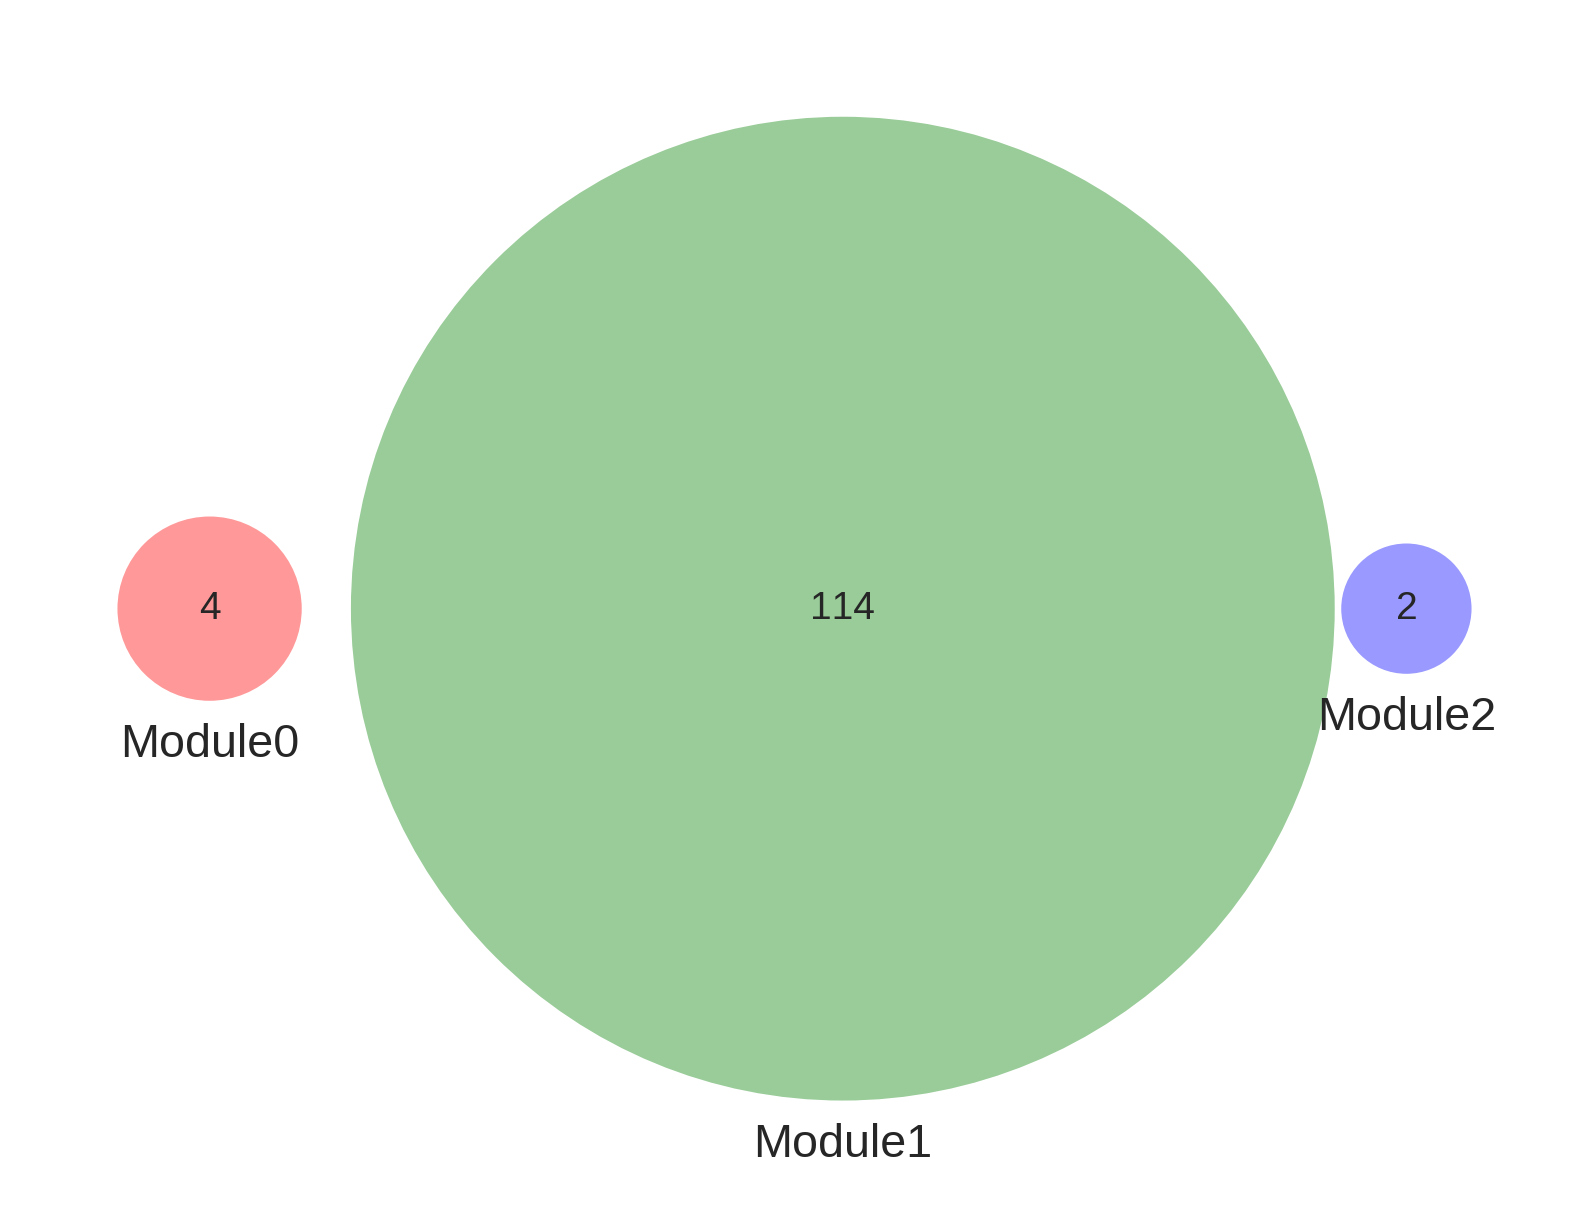

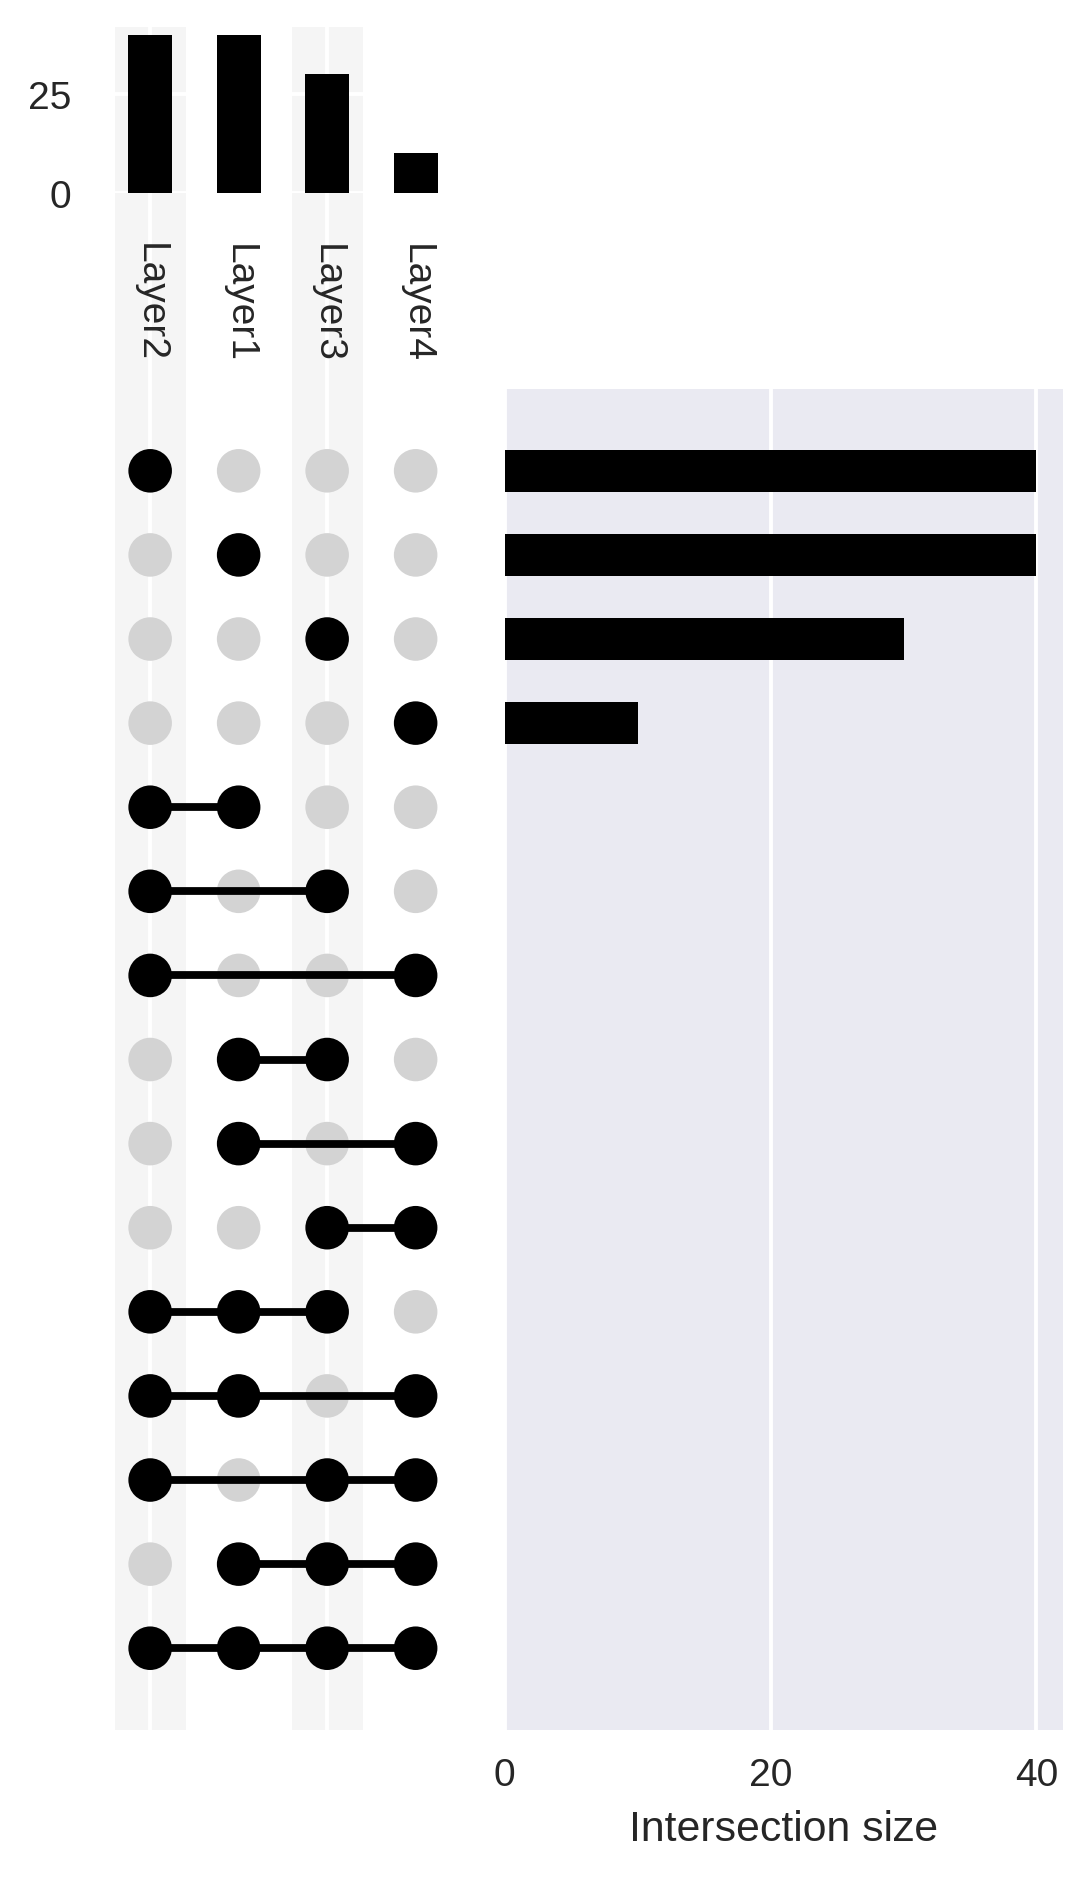

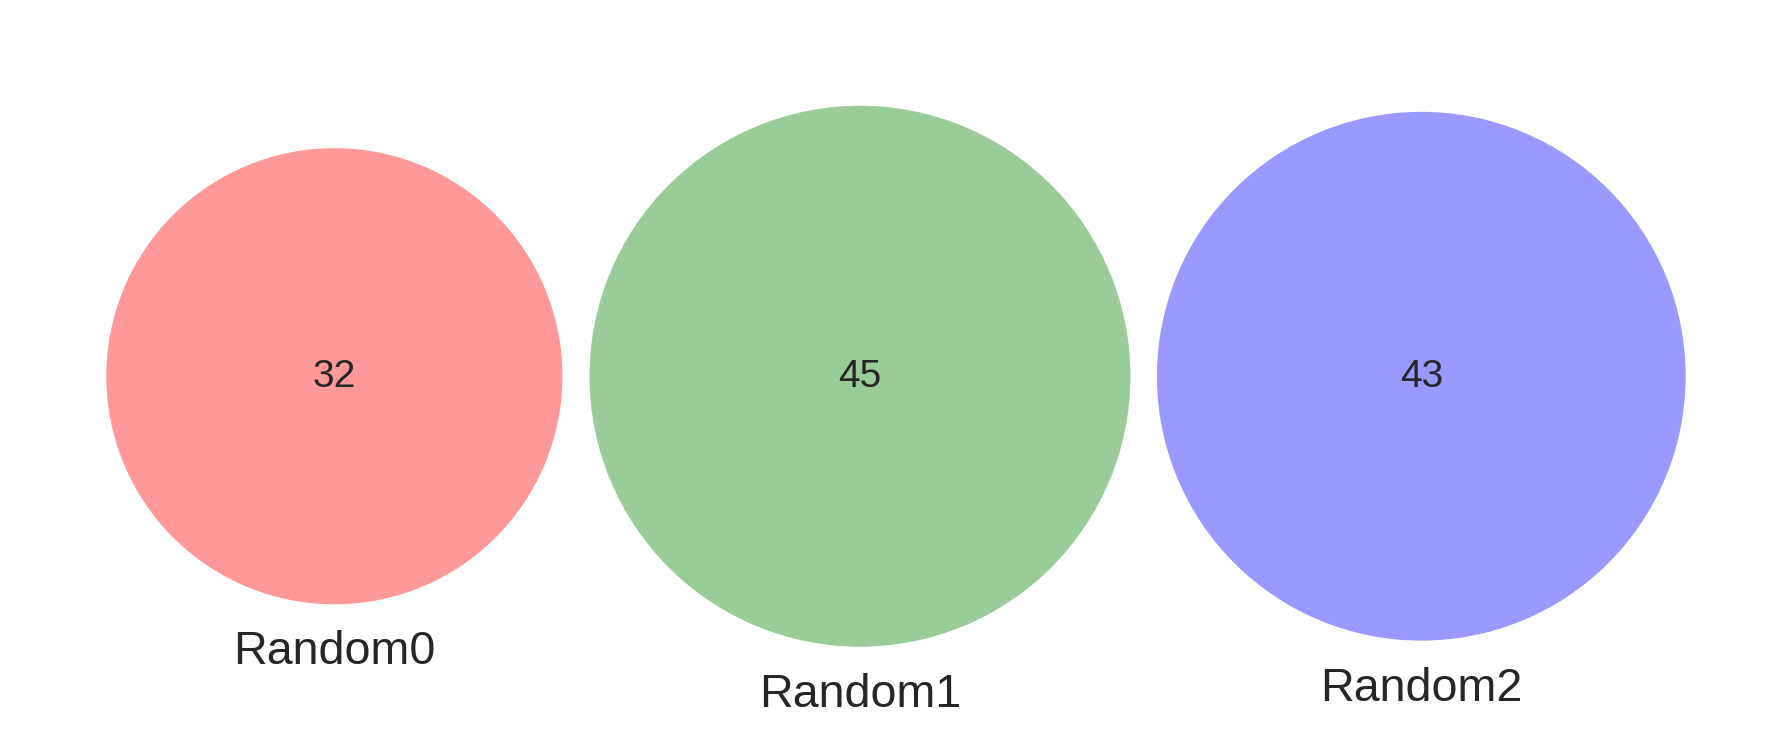

In [108]:
for grouping in groupings.items():
    name, i_group = grouping

    indices, counts = np.unique(i_group, return_counts=True)
    unions = {}
    for r in range(1, len(indices) + 1):
        for comb in itertools.combinations(zip(indices, counts), r):
            sub_indices, sub_counts = zip(*comb)
            key = " U ".join([f"{name}{i}" for i in sub_indices])
            value = sum(sub_counts)
            unions[key] = value
    print("Unions are:\n", ", ".join([f"{k}={v:.3g}" for k, v in unions.items()]))
    fig = plot_disjoint_subsets(unions, quantity="#neurons")


Unions for Module are Module0=4, Module1=34.2, Module2=2, Module0 U Module1=38, Module0 U Module2=6, Module1 U Module2=36.2, Module0 U Module1 U Module2=40
IDs w.r.t. Module are [ 3.80078125e+00  3.40000000e+01  1.99218750e-01  1.98046875e+00
 -0.00000000e+00  1.95312500e-02  0.00000000e+00].
Unions for Layer are Layer1=40, Layer2=13.2, Layer3=12.5, Layer4=9.62, Layer1 U Layer2=40, Layer1 U Layer3=40, Layer1 U Layer4=40, Layer2 U Layer3=13.2, Layer2 U Layer4=13.2, Layer3 U Layer4=12.5, Layer1 U Layer2 U Layer3=40, Layer1 U Layer2 U Layer4=40, Layer1 U Layer3 U Layer4=40, Layer2 U Layer3 U Layer4=13.2, Layer1 U Layer2 U Layer3 U Layer4=40
IDs w.r.t. Layer are [26.80078125  0.          0.70410156  0.         -0.         -0.
  2.87402344  0.         -0.         -0.         -0.         -0.
  0.          0.          9.62109375].
Unions for Random are Random0=22.4, Random1=22, Random2=21.9, Random0 U Random1=31.3, Random0 U Random2=31.2, Random1 U Random2=30.8, Random0 U Random1 U Random2=40

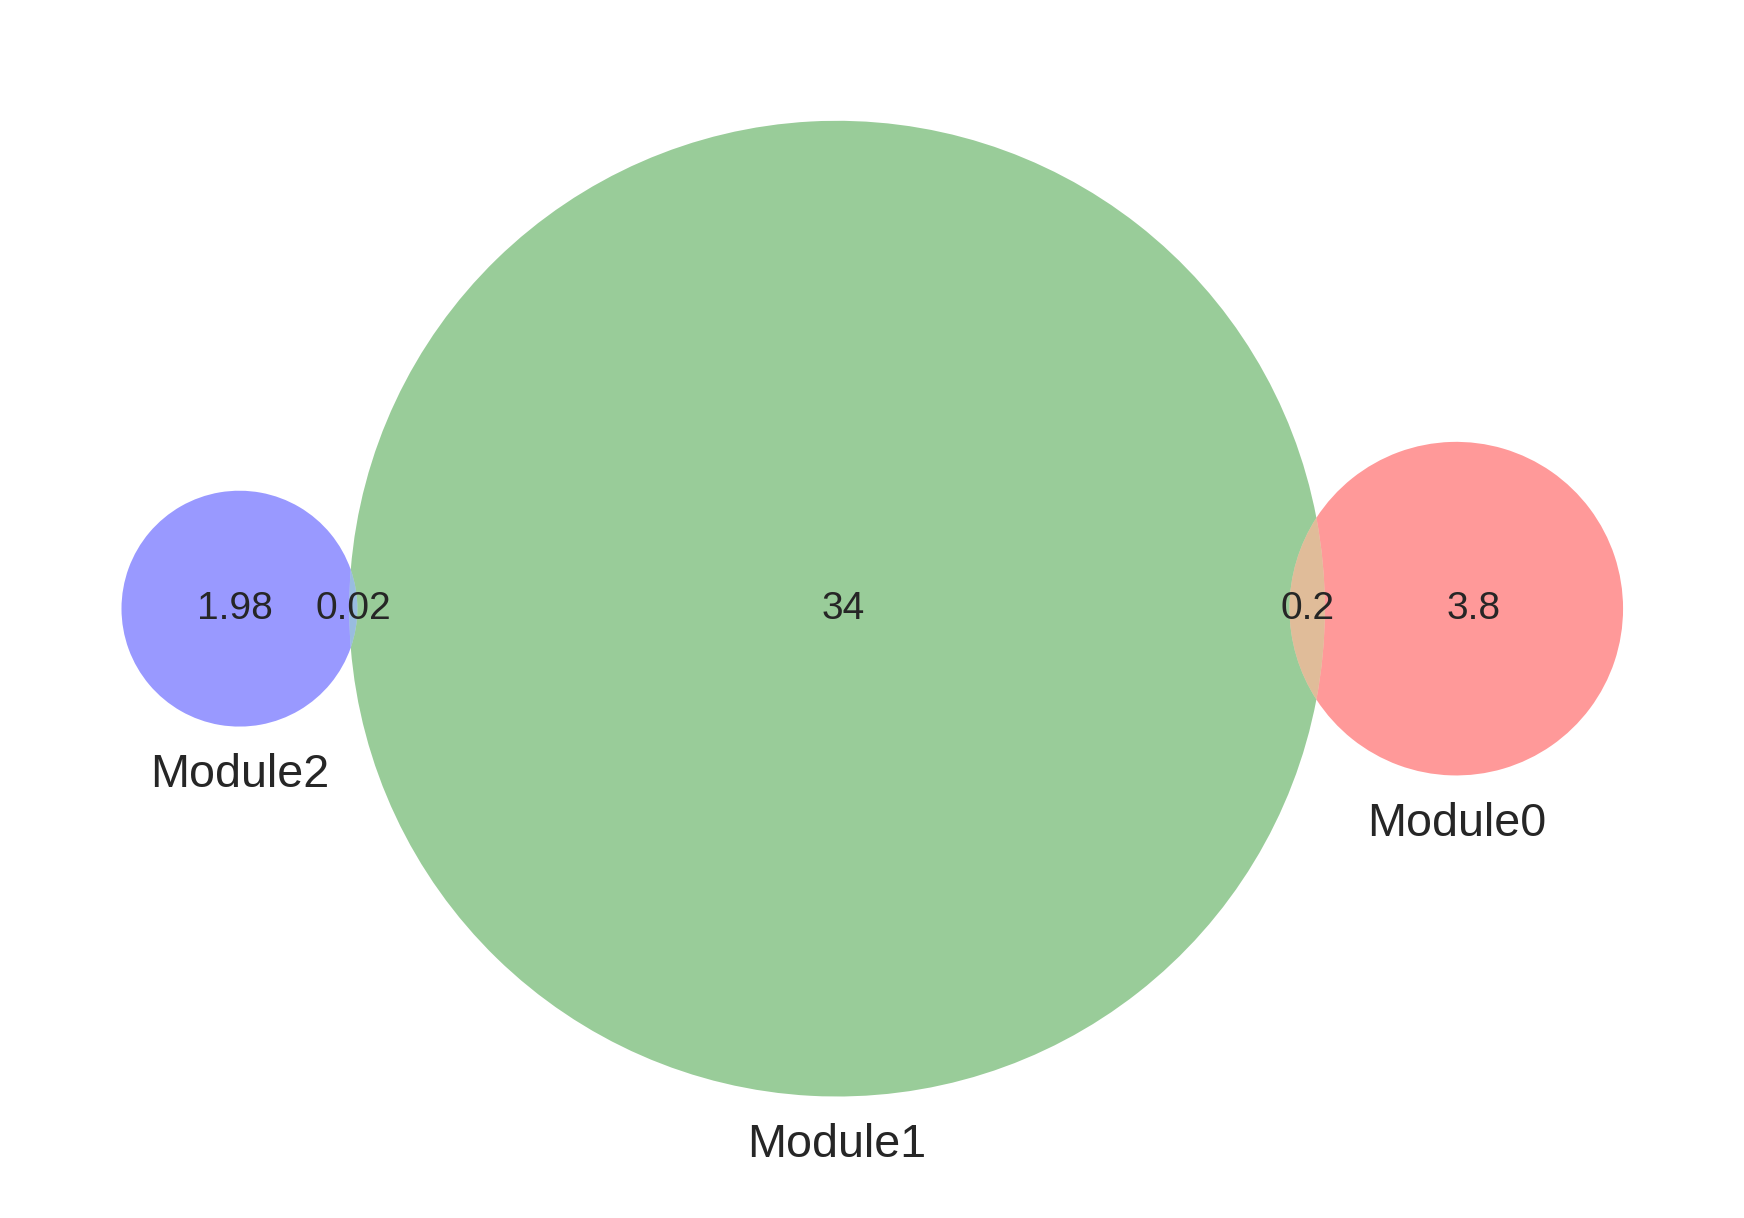

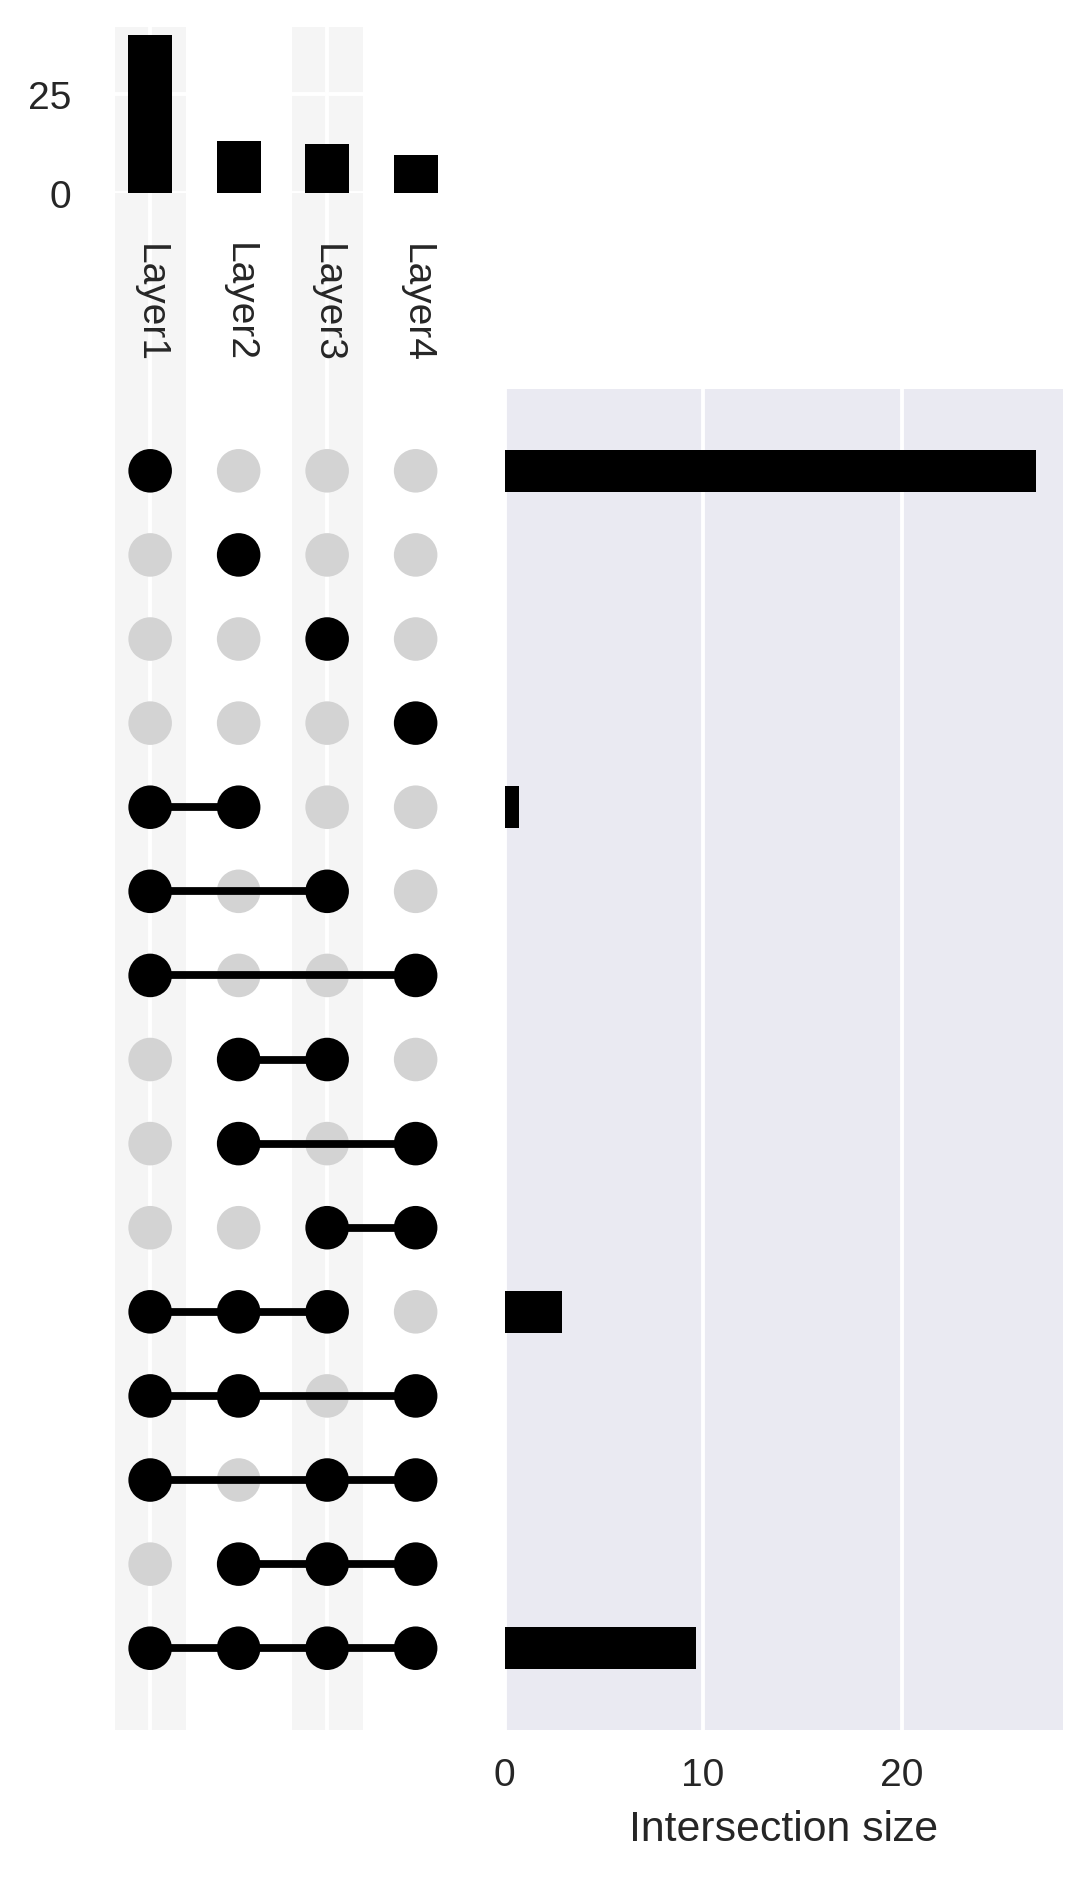

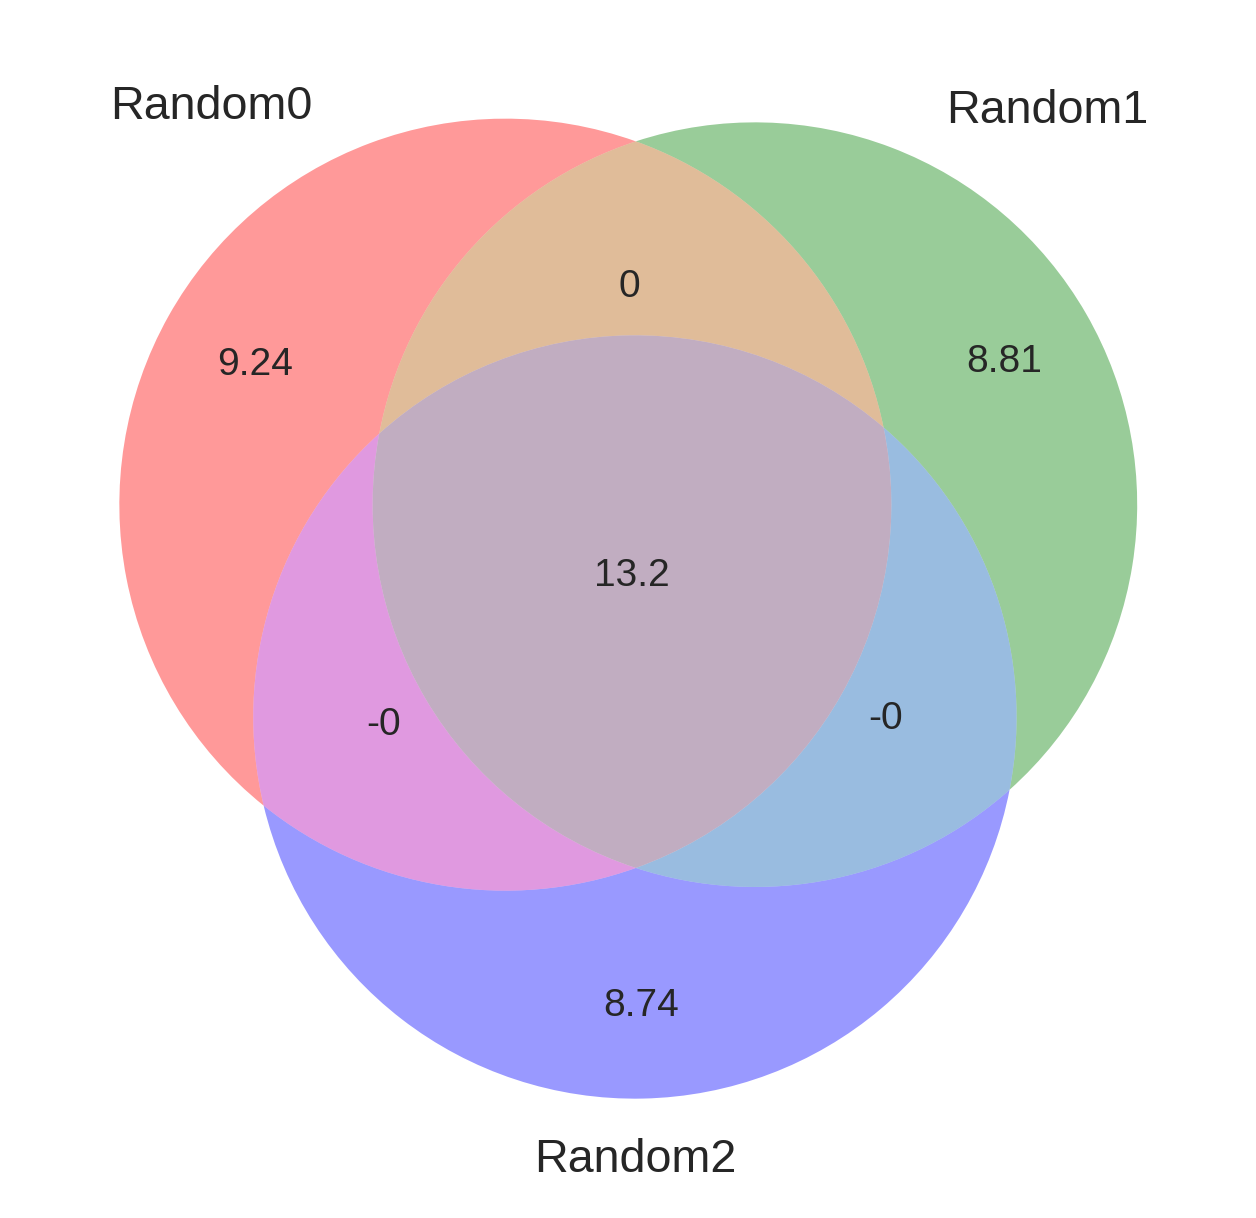

In [109]:
%%time
for grouping in groupings.items():
    name, i_group = grouping

    unions = get_intrinsic_dimensions(
        "jacobian",
        jac,
        torch.from_numpy(i_group),
        group_name=name,
    )
    print(f"Unions for {name} are", ", ".join([f"{k}={v:.3g}" for k, v in unions.items()]))
    fig = plot_disjoint_subsets(unions)


Unions for Module are: 
 Module0 =4.07, Module1 =9.35, Module2 =1.97, Module0 U Module1 =9.46, Module0 U Module2 =5.7, Module1 U Module2 =9.28, Module0 U Module1 U Module2 =9.47
IDs w.r.t. Module are [ 0.18746281  3.76892471  3.54932034  0.00993156 -0.0770998   1.6232276
  0.4102205 ].
Unions for Layer are: 
 Layer1 =9.56, Layer2 =7.94, Layer3 =6.71, Layer4 =5.29, Layer1 U Layer2 =9.52, Layer1 U Layer3 =9.51, Layer1 U Layer4 =9.55, Layer2 U Layer3 =7.94, Layer2 U Layer4 =7.94, Layer3 U Layer4 =6.63, Layer1 U Layer2 U Layer3 =9.48, Layer1 U Layer2 U Layer4 =9.51, Layer1 U Layer3 U Layer4 =9.51, Layer2 U Layer3 U Layer4 =7.93, Layer1 U Layer2 U Layer3 U Layer4 =9.47
IDs w.r.t. Layer are [ 1.54338551e+00 -3.51409912e-02  1.33065844e+00 -3.43208313e-02
  2.45237350e-02 -8.86440277e-03  1.36192322e+00 -7.78865814e-03
 -3.77464294e-03  7.06672668e-03 -7.31472969e-02 -1.97124481e-03
  9.34791565e-03 -7.84111023e-03  5.36793137e+00].


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: UserWarning: There were negative ID, this won't show right. Setting these to zero.


Unions for Random are: 
 Random0 =8.64, Random1 =8.77, Random2 =8.75, Random0 U Random1 =9.2, Random0 U Random2 =9.39, Random1 U Random2 =9.25, Random0 U Random1 U Random2 =9.47
IDs w.r.t. Random are [0.22642231 0.07846832 0.41526699 0.27044678 0.20951271 0.48199749
 7.78987312].
Unions for tSNE are: 
 tSNE0 =9.47
IDs w.r.t. tSNE are [9.47198772].
ID is 9.4719877243042.
CPU times: user 1.02 s, sys: 105 ms, total: 1.13 s
Wall time: 2.29 s


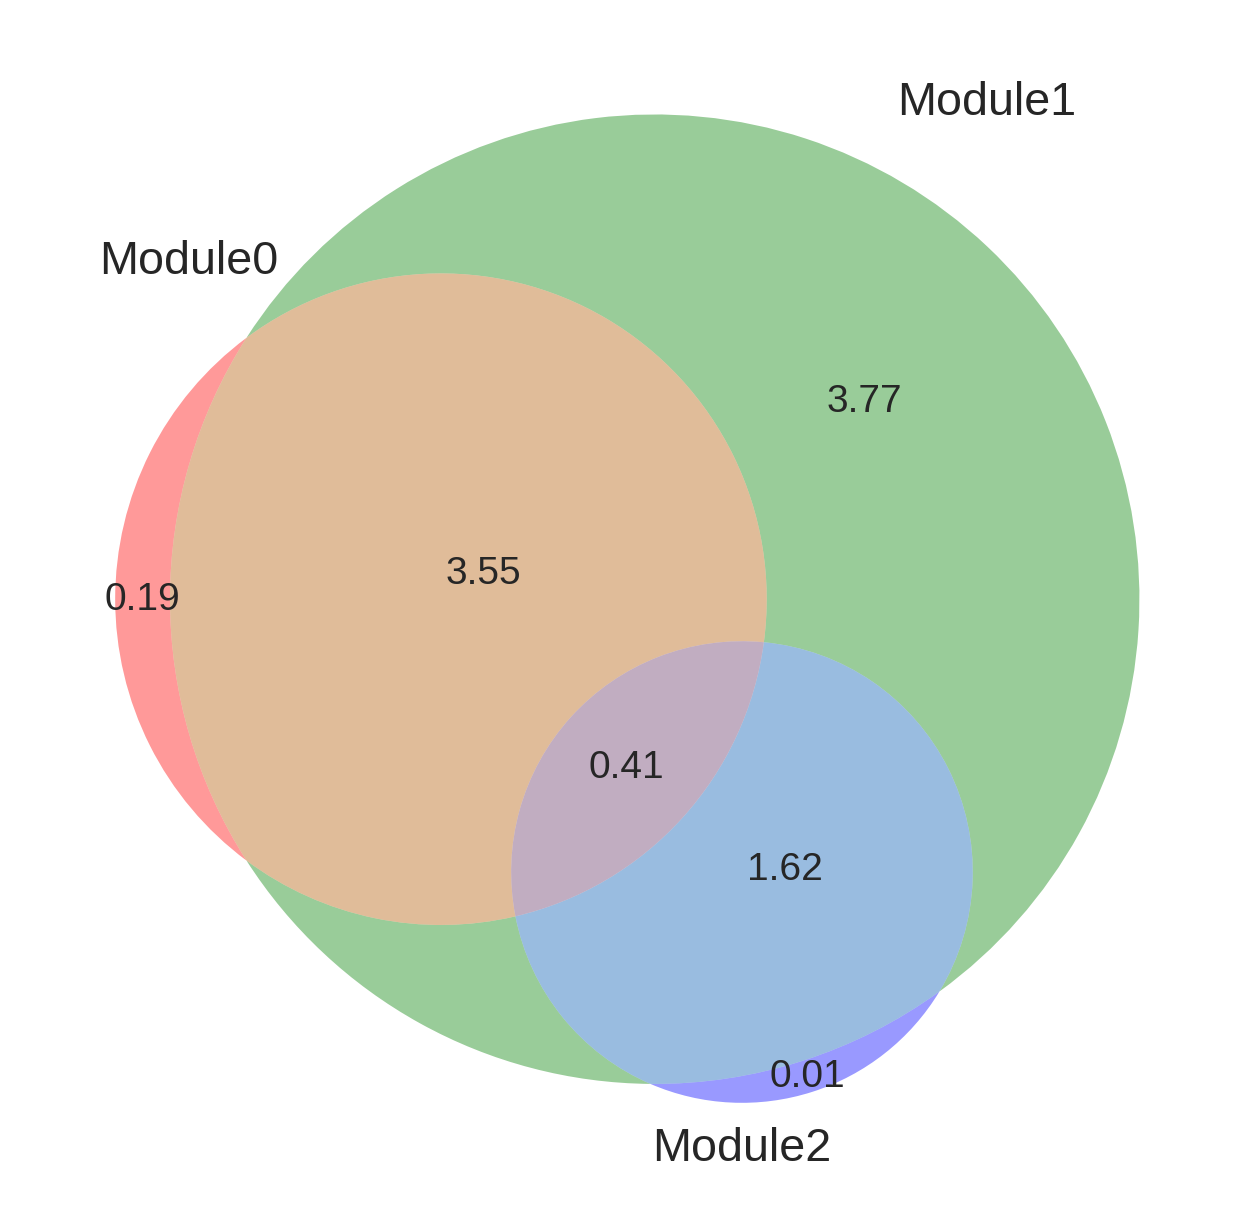

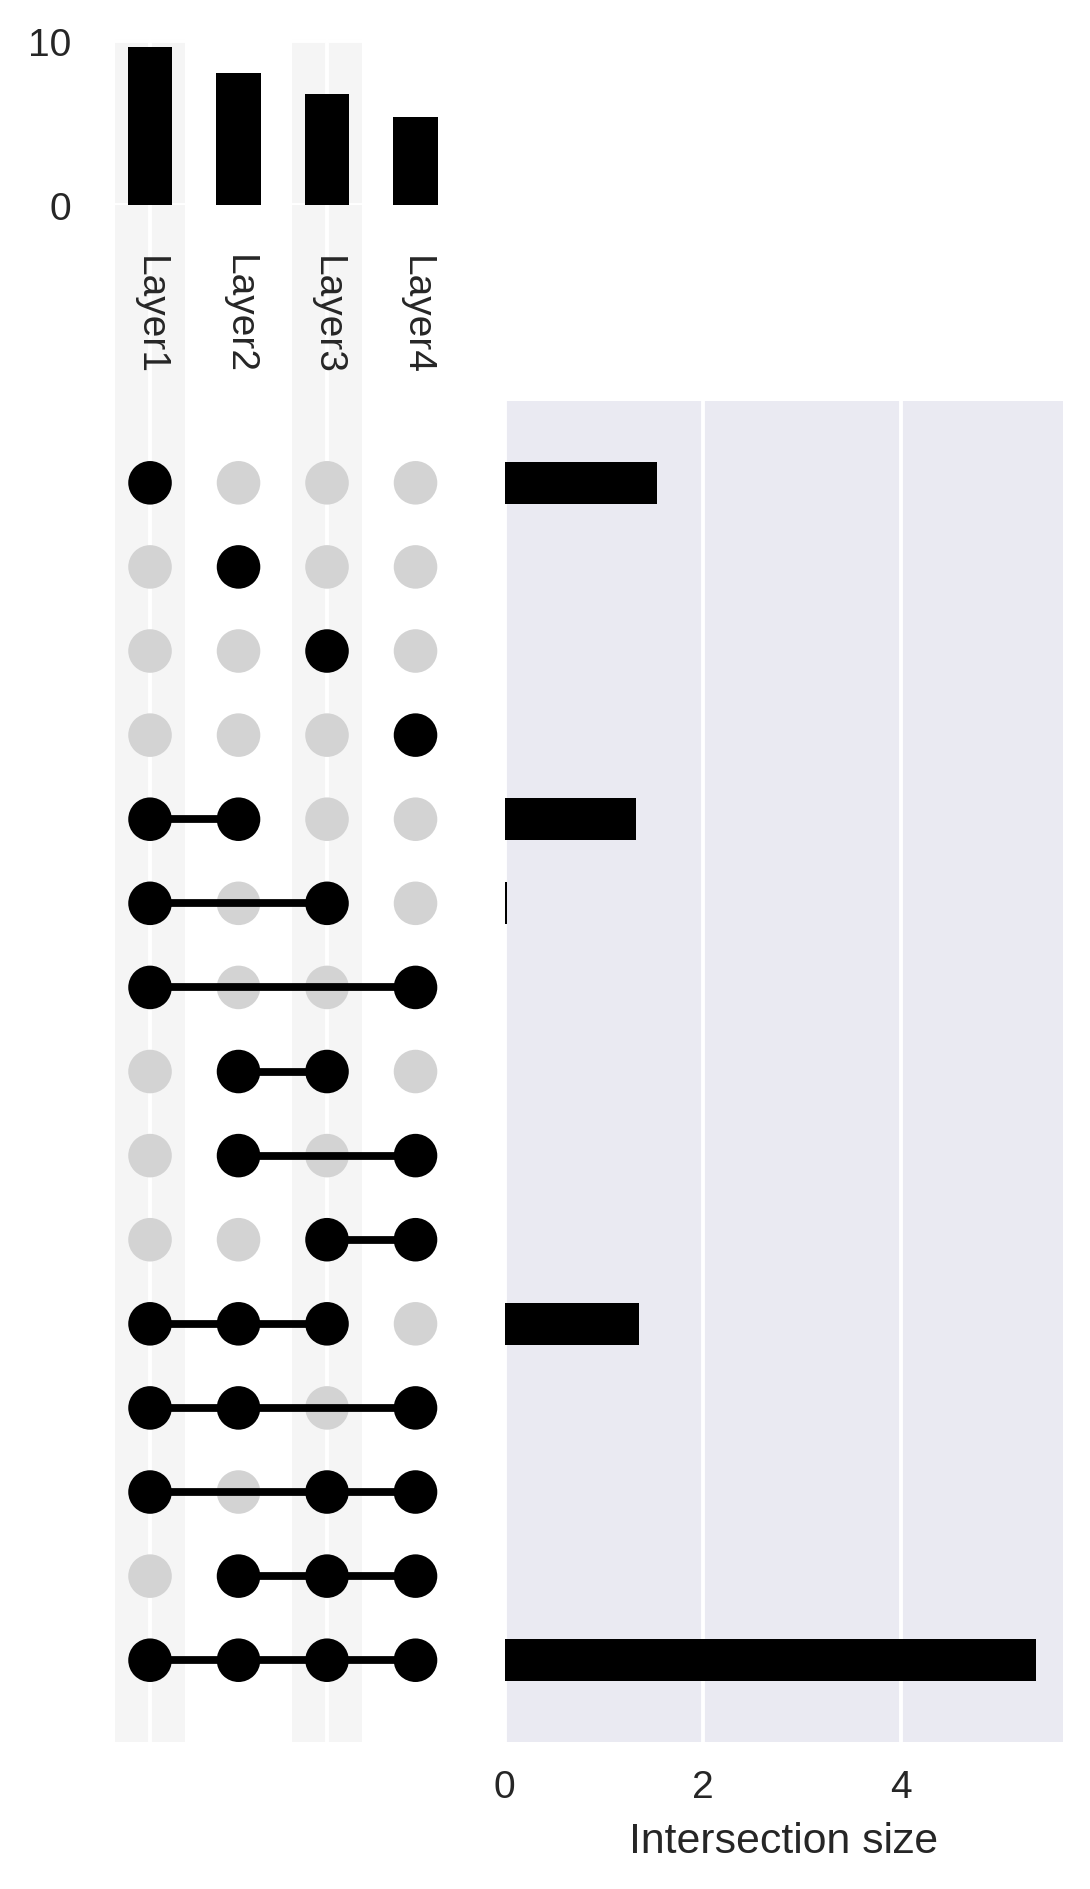

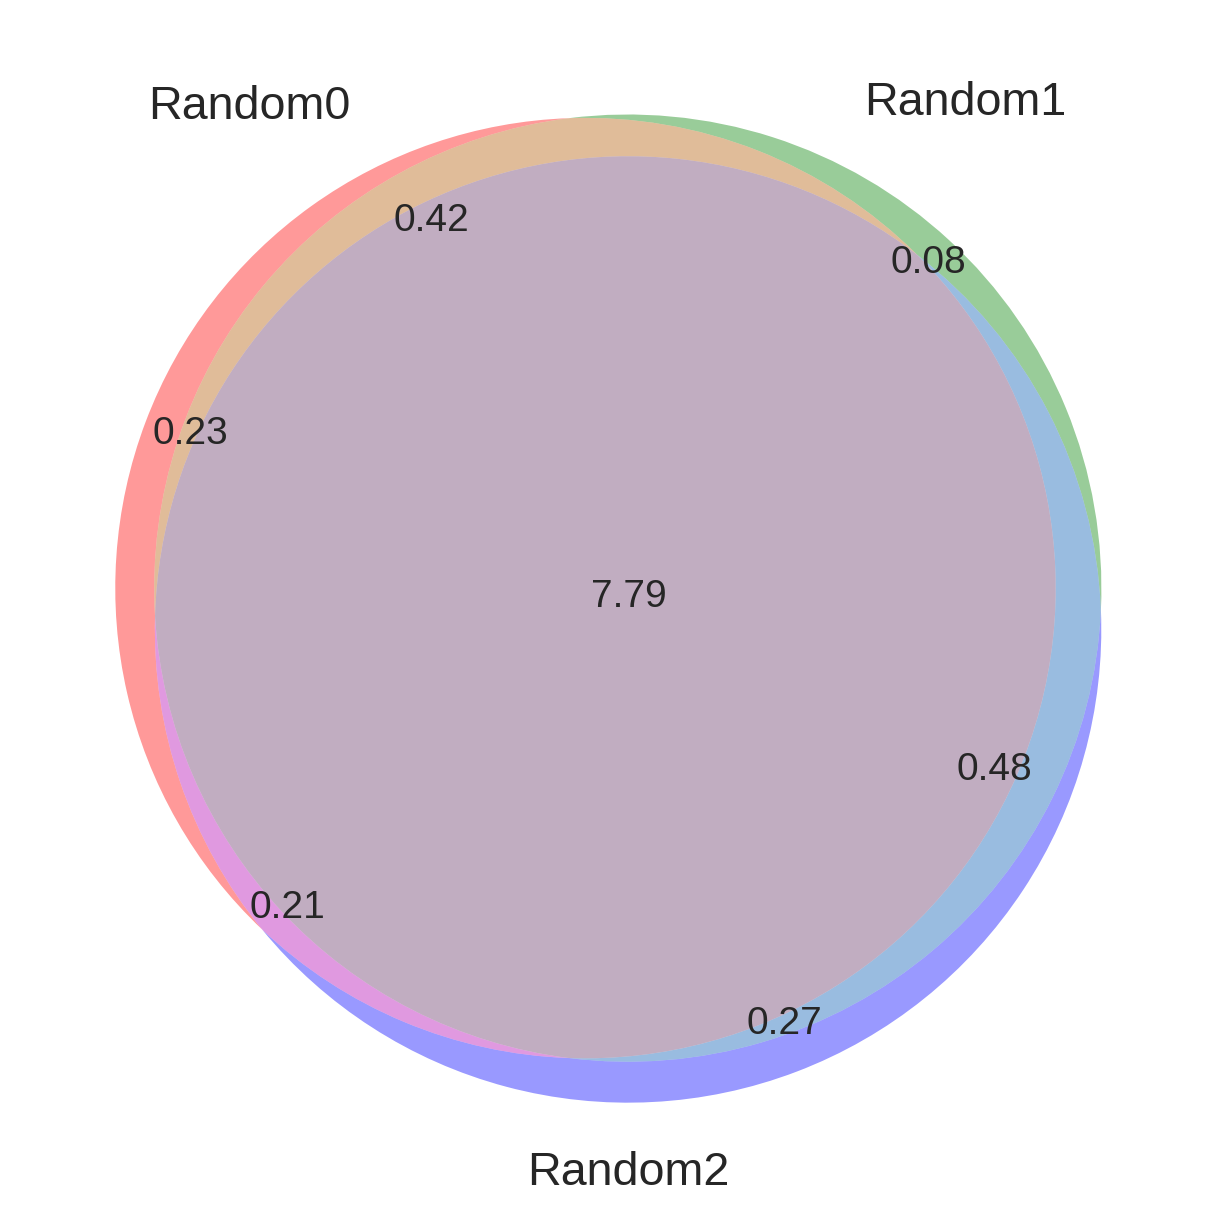

In [110]:
%%time
x = torch.vstack([x for x, y in testloader]).to(device)
activations = get_activations(mlp, x)

for grouping in groupings.items():
    name, i_group = grouping

    unions = get_intrinsic_dimensions(
        "twonn",
        activations,
        torch.from_numpy(i_group),
        group_name=name,
    )
    print(f"Unions for {name} are:", "\n", ", ".join([f"{k} ={v:.3g}" for k, v in unions.items()]))
    fig = plot_disjoint_subsets(unions)
